In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LinearRegression

# home_path = '/Users/evanli/Documents/'
# sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
# sys.path.append(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress')
# sys.path.append(home_path + 'EvanPys/Progress')
sys.path.append(str(source_code_dir))
from ADlasso2 import AD2_w_utils_lossdiff_noZ as ad

## Ignore section lambda decision
(Feature 數量為零之後的lambda就不要了)

In [3]:
# os.chdir(home_path + 'EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/tuning_result_cuda')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/tuning_result_cuda')

In [4]:
def ignore_section_lambda_decision(tuning_dict, celltype, k_seg, start_idx=0, version='new', output_dir=''):
    if version == 'new':
        # convert tuning_dict to old format
        tuning_old_format = {}
        for outer_key in tuning_dict.keys():
            for inner_key, value in tuning_dict[outer_key].items():
                if inner_key not in tuning_old_format.keys():
                    tuning_old_format[inner_key] = []
                tuning_old_format[inner_key].append(value)
    else:
        tuning_old_format = tuning_dict

    for key in tuning_old_format.keys():
        tuning_old_format[key] = np.array(tuning_old_format[key])
    
    # start index should be the index of lambda at which the BCE curve does not look strange
    if start_idx > 0:
        print('Start index:', start_idx)
    # Find the index of feature_number start to become 0
    cut_idx = len(tuning_old_format['Feature_number'])
    for i in range(len(tuning_old_format['Feature_number'])):
        if tuning_old_format['Feature_number'][i] <= 1:
            cut_idx = i
            print('Cut index:', cut_idx)
            break

    trimmed_tuning = {}
    for k in tuning_old_format.keys():
        trimmed_tuning[k] = tuning_old_format[k][start_idx:cut_idx]

    def plot_lambda_decision(tuning, celltype, opt_lmbd, cut_idx, seg_var=tuple(), start_idx=0, savepath=''):
        fig, ax1 = plt.subplots(figsize = (8, 5))
        ax2 = ax1.twinx()

        line1, = ax1.plot(np.exp(tuning['log_lambda_range']), tuning['loss_history'], marker='o', color='blue')
        line2, = ax2.plot(np.exp(tuning['log_lambda_range']), tuning['Feature_number'], marker='o', color='orange')
        ax1.set(xscale="log")

        # vertical line for optimal lambda
        plt.axvline(x=opt_lmbd, color = 'black', linestyle=':')
        
        # vertical line for start lambda (blue)
        if start_idx > 0:
            # only plot the start line when the start_idx is not the first index
            print('Start:', np.exp(tuning['log_lambda_range'][start_idx]))
            # vertical line for start lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][start_idx]), color = 'blue', linestyle=':')
        # vertical line for cut lambda (red)
        if cut_idx < len(tuning['log_lambda_range']):
            # only plot the cut line when the cut_idx is not the last index
            print('Cut:', np.exp(tuning['log_lambda_range'][cut_idx]))
            # vertical line for cut lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][cut_idx]), color = 'red', linestyle=':')
        
        # horizontal line for feature number = 0 (this does not make sense with y log scale)
        # plt.axhline(y=0, color = 'black', linestyle='--')

        ax1.set_xlabel(f"lambda (optimal: {opt_lmbd})")
        ax1.set_ylabel("Loss"); ax2.set_ylabel("Feature number")
        ax2.set_yscale("log")  # set log scale for feature number
        ax2.set_ylim(bottom=0.5, top=None)  # set ylim for feature number  # EDITTED
        ax1.set_title(f'{celltype} lambda decision')
        plt.legend(handles=[line1, line2], labels=['BCE loss', 'Feature_number'], loc='upper left')

        # Plot the split k segments
        if seg_var:
            xs, ys, dys_dt, ys_sl = seg_var
            for y in np.unique(dys_dt):
                msk = dys_dt == y
                lin_reg = LinearRegression()
                lin_reg.fit(xs[msk].reshape(-1, 1), ys[msk].reshape(-1, 1))
                ys_sl[msk] = lin_reg.predict(xs[msk].reshape(-1, 1)).flatten()
                # X軸有log-scale, Y軸沒有 log-scale, 所以X軸要用np.exp()還原
                ax1.plot(np.exp([xs[msk][0], xs[msk][-1]]), [ys_sl[msk][0], ys_sl[msk][-1]], color='r', zorder=5, linewidth = 2)

        if savepath:
            plt.savefig(savepath, dpi=300)

    # Lambda decision from trimmed tuning result
    # TODO: reset k value of lambda decision
    opt_lmbd, candidates, fig, segment_variables = ad.lambda_decision(trimmed_tuning, k=k_seg, savepath=output_dir + f'{celltype}_k{k_seg}_lambda_decision_trimmed.png')
    print('Optimal lambda:', opt_lmbd)
    log_opt_lmbd = np.log(opt_lmbd)

    log_lambda_range = tuning_old_format['log_lambda_range']
    opt_idx = np.where(log_lambda_range == log_opt_lmbd)[0][0]

    feature_no_celltype = int(tuning_old_format['Feature_number'][opt_idx])
    print('Feature no:', feature_no_celltype)

    # Plot lambda vs. prevalence and lambda vs. loss
    plot_lambda_decision(tuning_old_format, celltype, opt_lmbd, cut_idx, seg_var=segment_variables, start_idx=start_idx, savepath=output_dir + f'{celltype}_k{k_seg}_lambda_decision_all.png')

    return opt_lmbd, feature_no_celltype

In [5]:
queue = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

In [6]:
### Function for running lambda decision for a single cell types
def run_lmbd_decision(celltype, k_seg, start_idx=0, output_dir=''):
    tuning_file = f'{celltype}_tuning.json'
    if not os.path.exists(tuning_file):
        print(f"File {tuning_file} does not exist. Skipping to the next cluster.")
        return

    print('====================')
    print(f'Cell type: {celltype}')
    with open(tuning_file) as f:
        tuning = json.load(f)

    opt_lmbd, feature_no_celltype = ignore_section_lambda_decision(tuning, celltype, k_seg=k_seg, start_idx=start_idx, version='old', output_dir=output_dir)
    # opt_lmbd_dict[celltype] = opt_lmbd
    # feature_no_dict[celltype] = feature_no_celltype
    return opt_lmbd, feature_no_celltype

## k = 3

B Start index: 0
Cell type: B
Optimal lambda: 0.003162277660168382
Feature no: 17
CD4_T Start index: 0
Cell type: CD4_T
Optimal lambda: 0.0014677992676220694
Feature no: 191
CD8_T Start index: 0
Cell type: CD8_T
Optimal lambda: 0.006812920690579613
Feature no: 27
DC Start index: 0
Cell type: DC
Optimal lambda: 0.0010000000000000002
Feature no: 49
Mono Start index: 0
Cell type: Mono
Optimal lambda: 0.003162277660168382
Feature no: 52
NK Start index: 0
Cell type: NK
Optimal lambda: 0.006812920690579613
Feature no: 32
other Start index: 0
Cell type: other
Optimal lambda: 0.014677992676220709
Feature no: 5
other_T Start index: 0
Cell type: other_T
Optimal lambda: 0.00046415888336127795
Feature no: 250


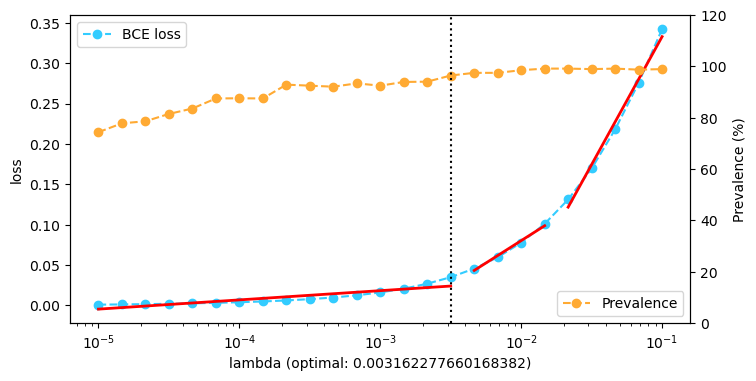

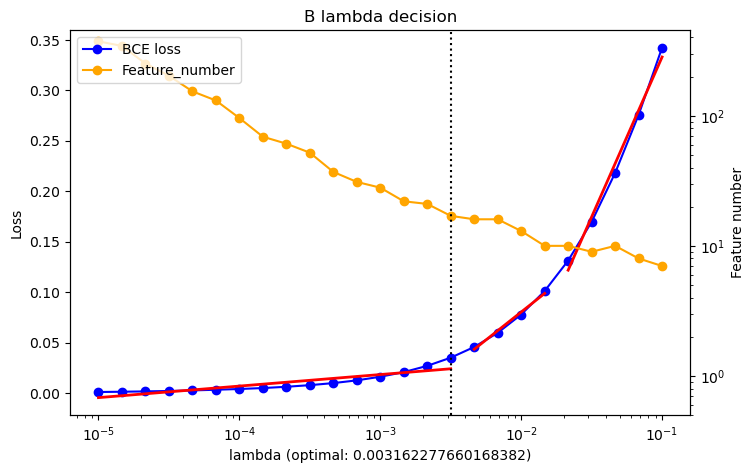

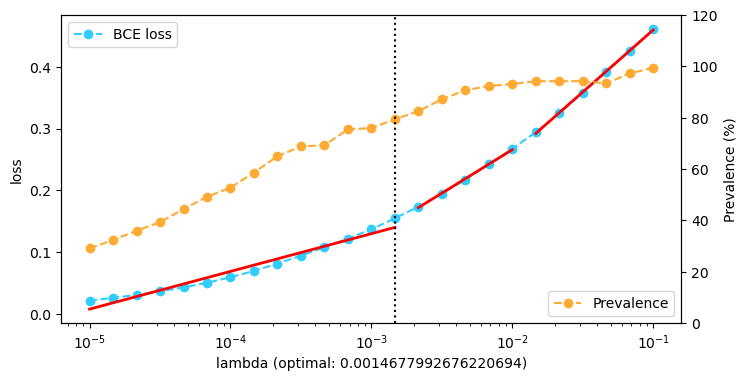

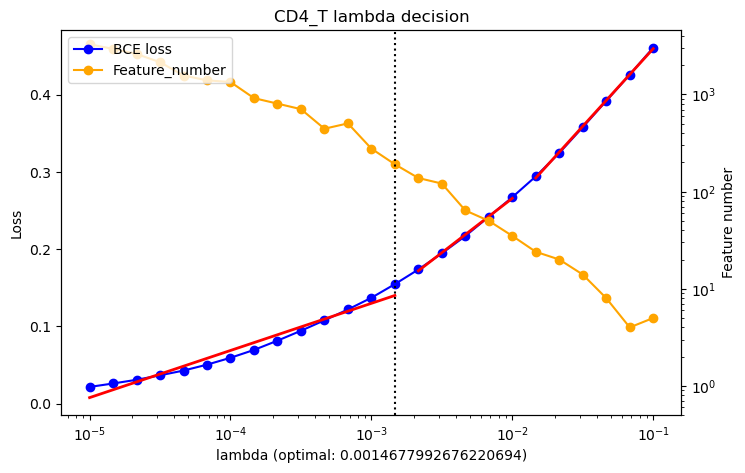

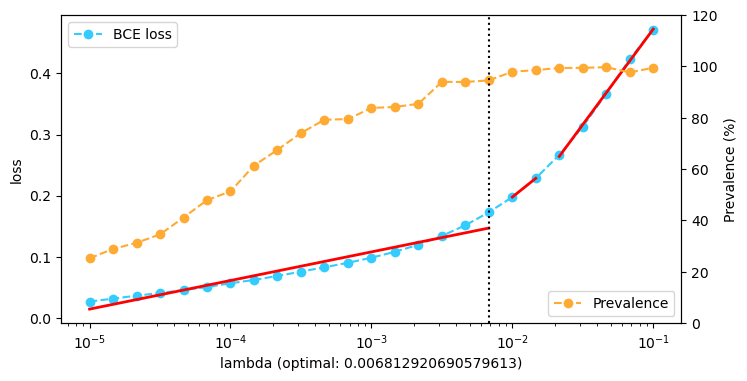

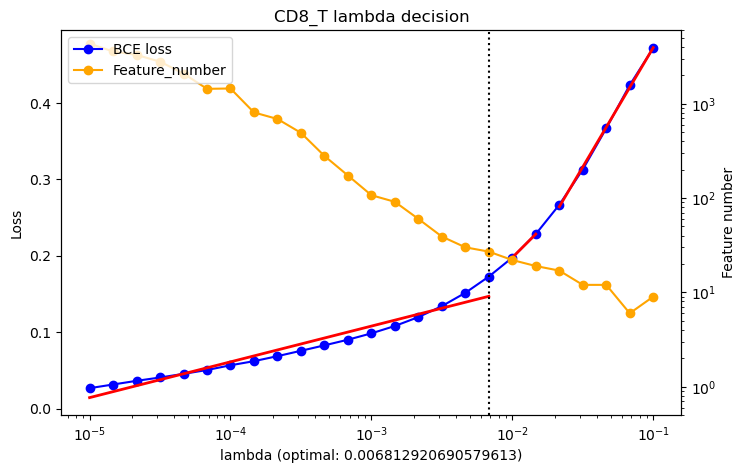

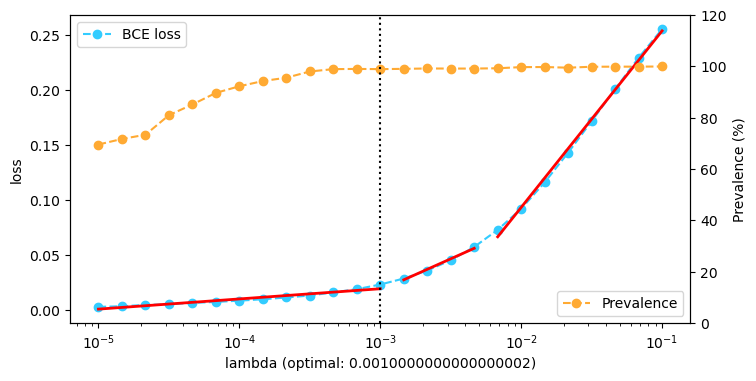

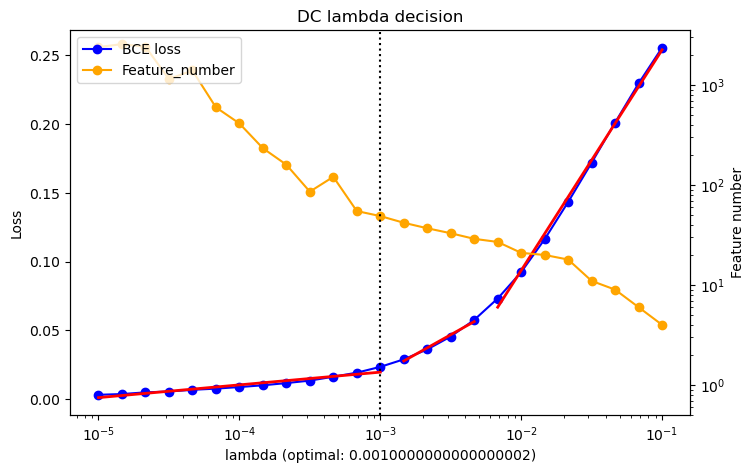

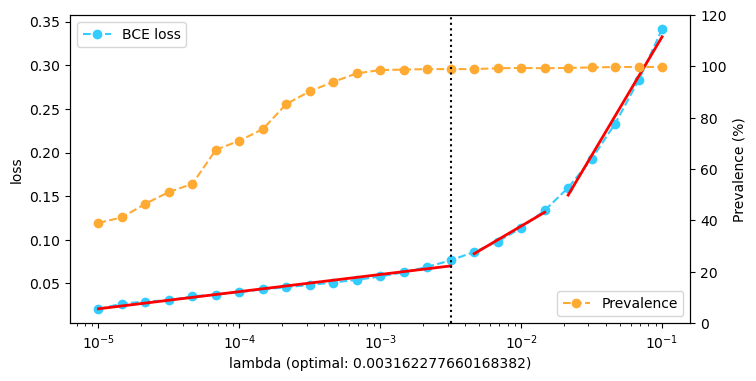

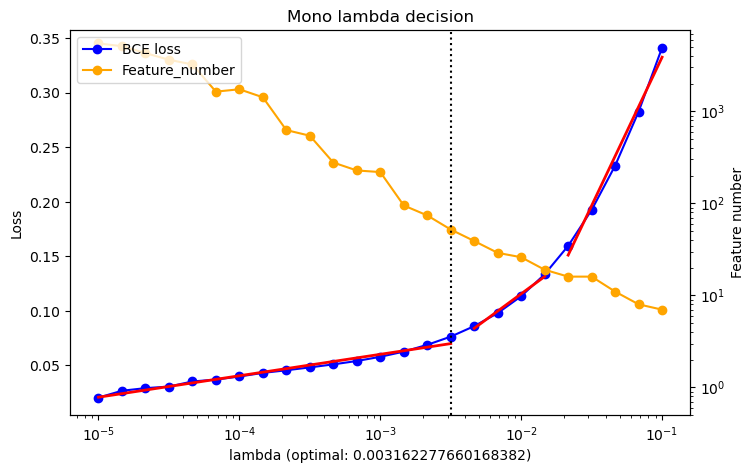

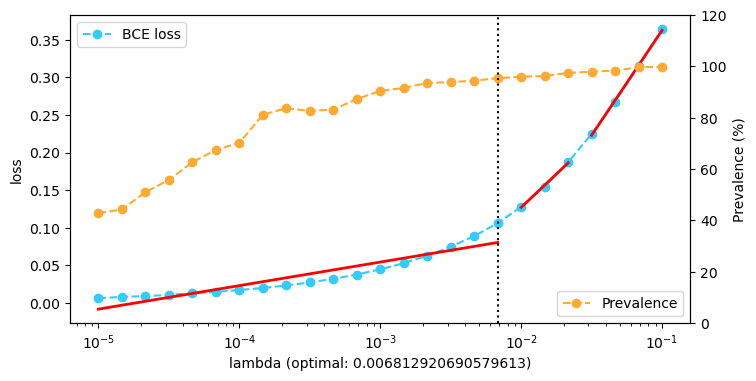

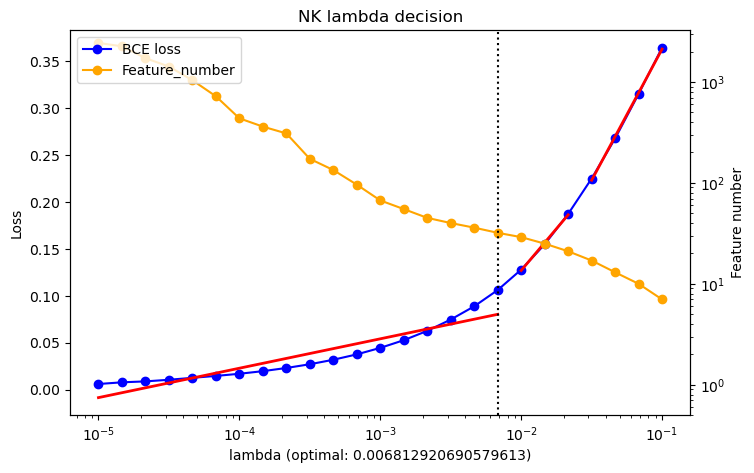

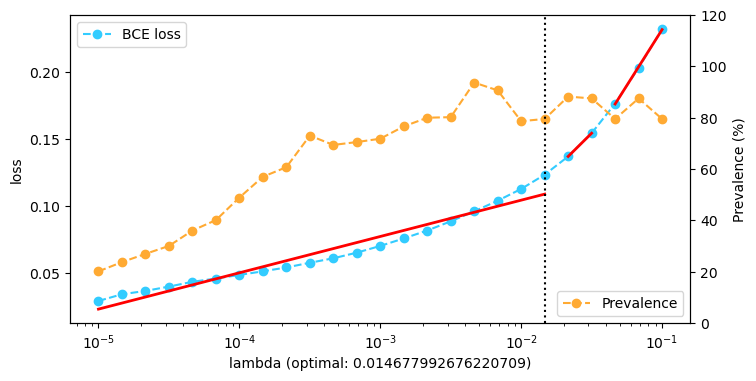

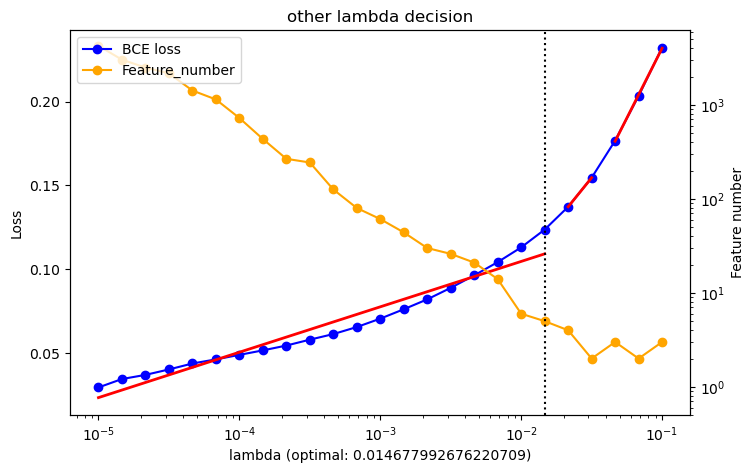

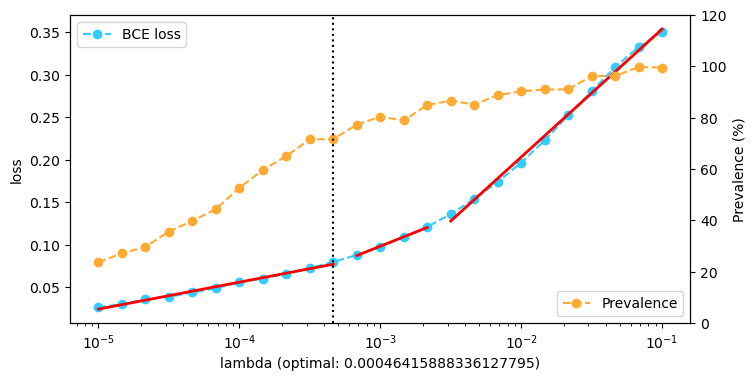

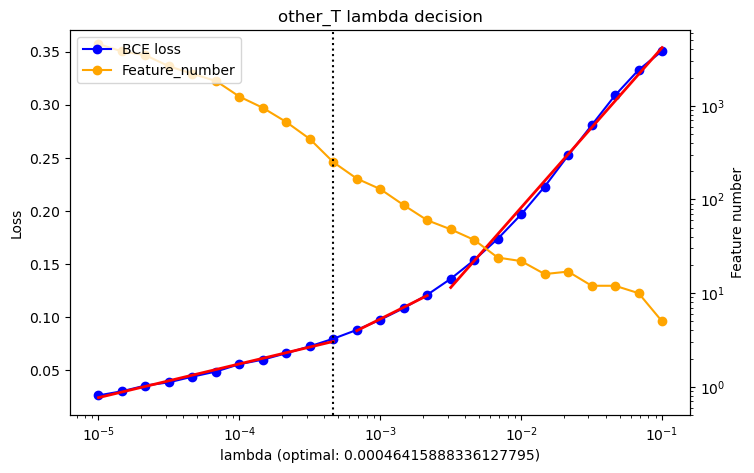

In [ ]:
# os.chdir(home_path + 'EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/tuning_result_cuda')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/tuning_result_cuda')
# Start index for each cell type
start_idx_dict = {
}
opt_lmbd_dict_k3 = {}
feature_no_dict_k3 = {}

# dir = home_path + 'EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/lambda_decision_plot_seg/'
dir = source_code_dir / 'PBMC_Hao_batch_noZ/Level1/lambda_decision_plot_seg/'
for celltype in queue:
    start_idx = start_idx_dict.get(celltype, 0)
    print('====================')
    print(celltype, 'Start index:', start_idx)
    opt_lmbd_dict_k3[celltype], feature_no_dict_k3[celltype] = run_lmbd_decision(celltype, k_seg=3, start_idx=start_idx, output_dir=dir)

In [9]:
opt_lmbd_dict_k3

{'B': 0.003162277660168382,
 'CD4_T': 0.0014677992676220694,
 'CD8_T': 0.006812920690579613,
 'DC': 0.0010000000000000002,
 'Mono': 0.003162277660168382,
 'NK': 0.006812920690579613,
 'other': 0.014677992676220709,
 'other_T': 0.00046415888336127795}

In [10]:
feature_no_dict_k3

{'B': 17,
 'CD4_T': 191,
 'CD8_T': 27,
 'DC': 49,
 'Mono': 52,
 'NK': 32,
 'other': 5,
 'other_T': 250}

In [7]:
# os.chdir(home_path + 'EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/lambda_decision')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/lambda_decision')

In [30]:
with open('L1c_k3_opt_lmbd.json', 'w') as f:
    json.dump(opt_lmbd_dict_k3, f)